In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

# Загрузим данные о составе стекла и его типах

In [2]:
df = pd.read_csv('glass.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


Пропусков в данных нет

# Проведем первичный анализ

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
RI,214.0,1.518365,0.003037,1.51115,1.516522,1.51768,1.519157,1.53393
Na,214.0,13.407850,0.816604,10.73000,12.907500,13.30000,13.825000,17.38000
Mg,214.0,2.684533,1.442408,0.00000,2.115000,3.48000,3.600000,4.49000
Al,214.0,1.444907,0.499270,0.29000,1.190000,1.36000,1.630000,3.50000
Si,214.0,72.650935,0.774546,69.81000,72.280000,72.79000,73.087500,75.41000
K,214.0,0.497056,0.652192,0.00000,0.122500,0.55500,0.610000,6.21000
Ca,214.0,8.956963,1.423153,5.43000,8.240000,8.60000,9.172500,16.19000
Ba,214.0,0.175047,0.497219,0.00000,0.000000,0.00000,0.000000,3.15000
Fe,214.0,0.057009,0.097439,0.00000,0.000000,0.00000,0.100000,0.51000
Type,214.0,2.780374,2.103739,1.00000,1.000000,2.00000,3.000000,7.00000


In [5]:
df['Type'].value_counts()

2    76
1    70
7    29
3    17
5    13
6     9
Name: Type, dtype: int64

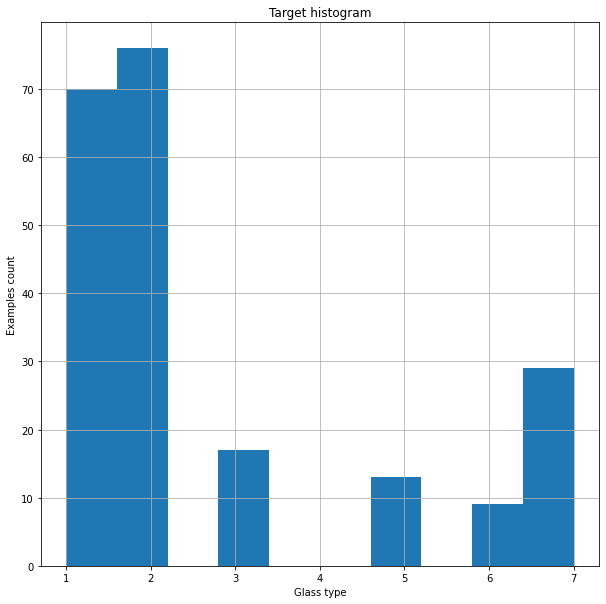

In [6]:
plt.figure(figsize=(10, 10))
df['Type'].hist()
plt.title('Target histogram')
plt.xlabel('Glass type')
plt.ylabel('Examples count')
plt.show()

Видно, что распределение примеров неравномерное для каждого из типов, а 4й тип отсутствует вовсе

# Разделим выборку на train, test части, построим модель

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(df.drop(columns=['Type']), df['Type'], test_size=0.2, random_state=0)

model = RandomForestClassifier(max_depth=2, random_state=0)

model.fit(X_train, Y_train)

RandomForestClassifier(max_depth=2, random_state=0)

Посчитаем точность модели:

In [8]:
result_before = round(model.score(X_test, Y_test), 3)
result_before

0.512

# Обработаем выбросы в данных

Для каждого признака построим `boxplot` и `histplot`:

column='RI'


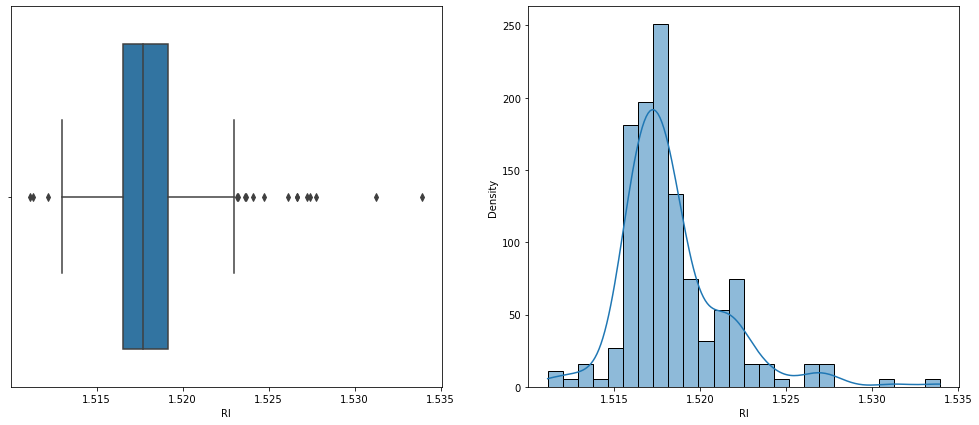

column='Na'


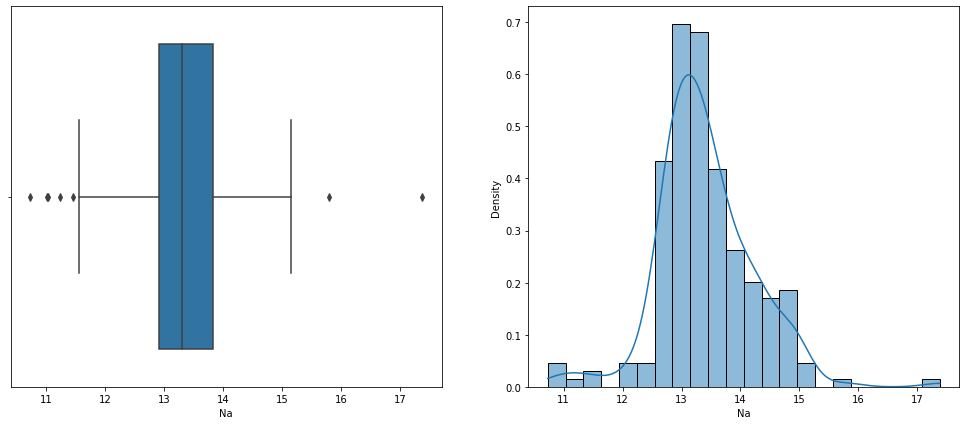

column='Mg'


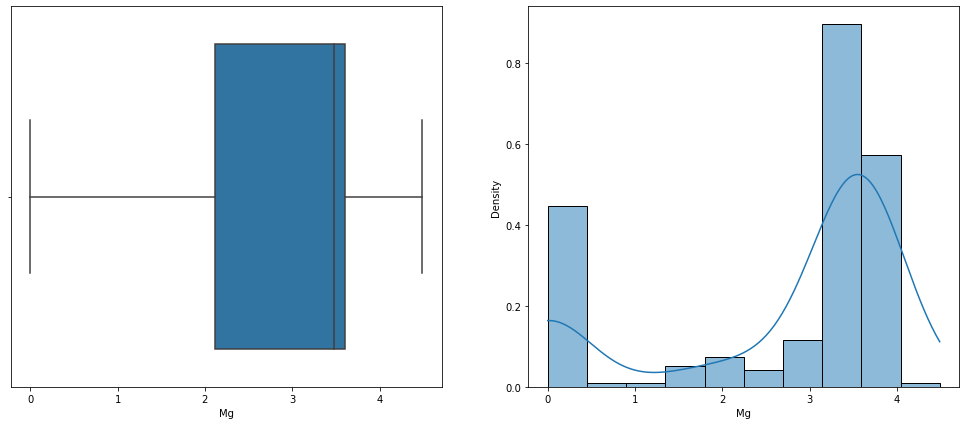

column='Al'


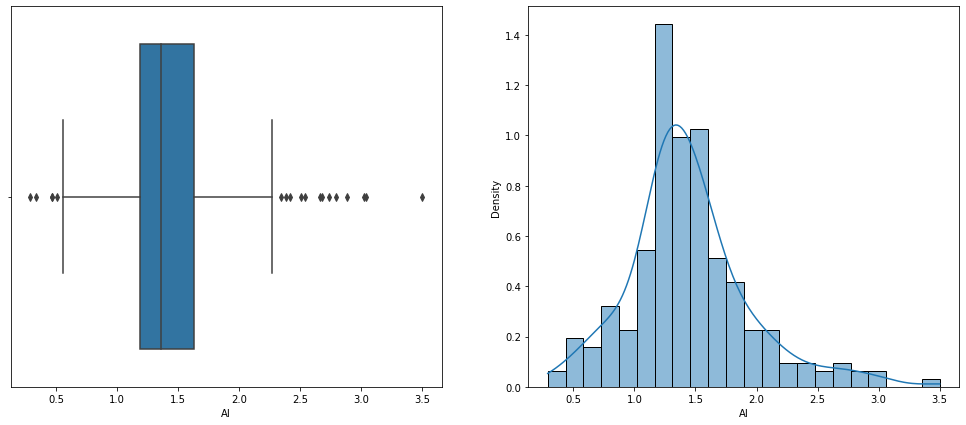

column='Si'


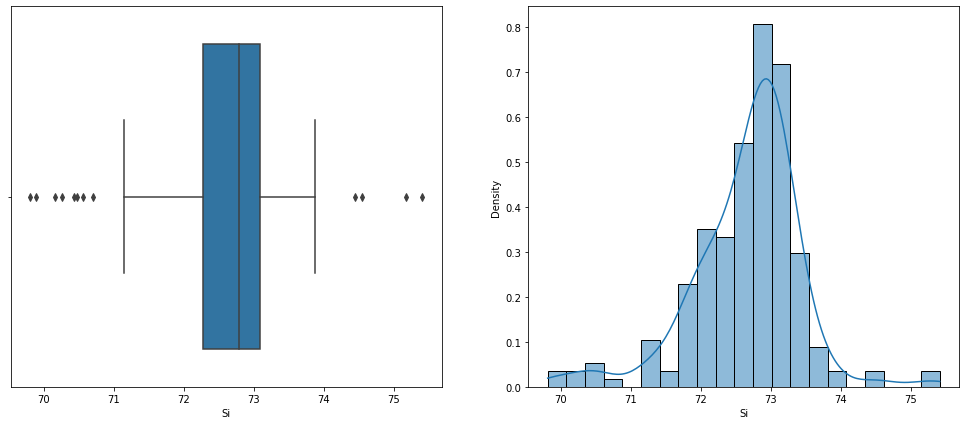

column='K'


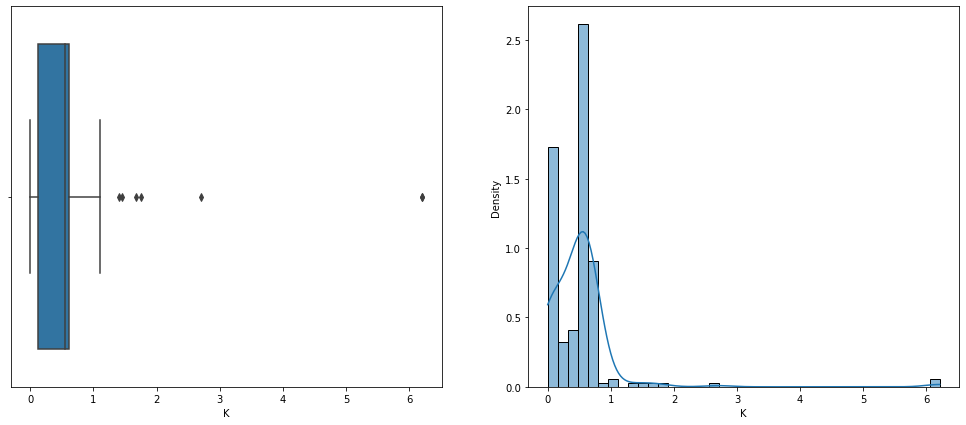

column='Ca'


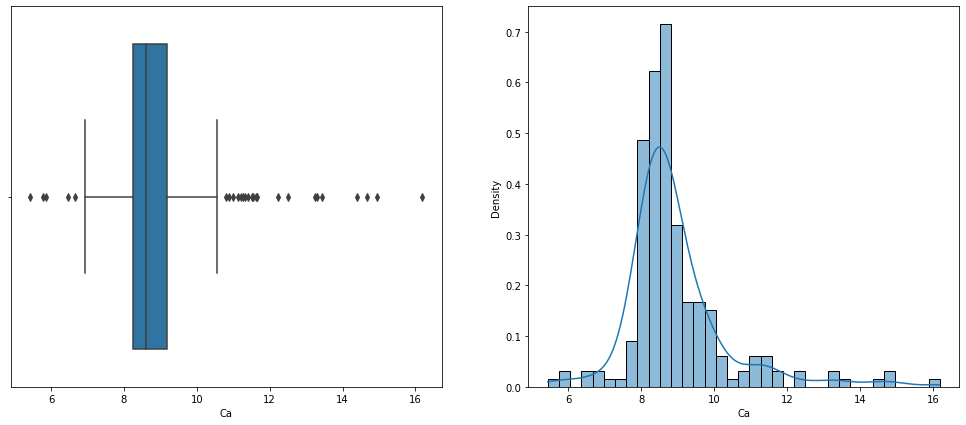

column='Ba'


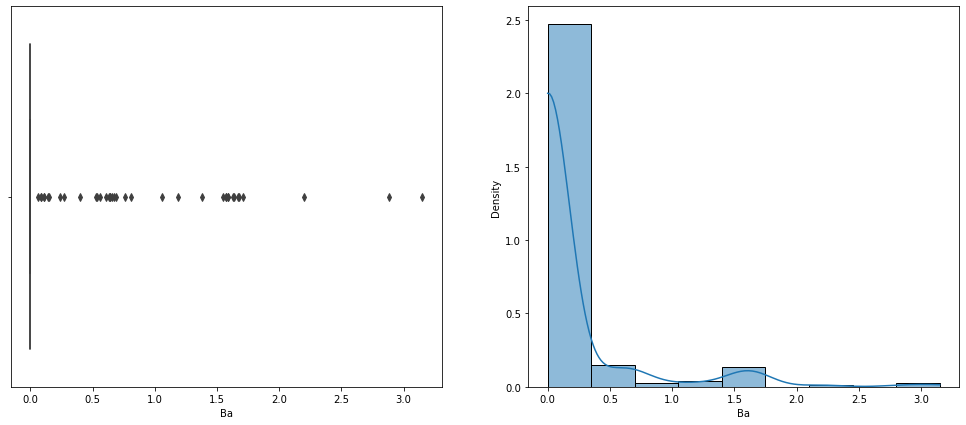

column='Fe'


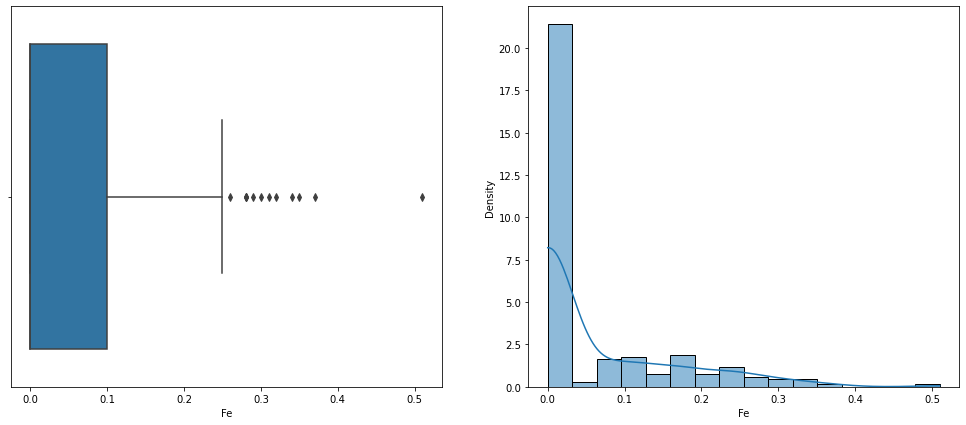

In [9]:
for column in df.drop(columns='Type').columns:
    print(f'{column=}')
    f, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(17, 7))
    sns.boxplot(x=df[column], ax=ax1)
    sns.histplot(df[column], kde=True, stat="density", ax=ax2)
    plt.show()

По графикам видно, что признаки `RI`, `Na`, `Al`, `Si`, `Ca` похожи на нормальные распределения. Кроме того, есть признаки с явными выбросами

Рассчитаем +/- 2 стандартных отклонения для каждого признака, чтобы соотнести значения с графиками и выбрать подходящие пороги для отсеивания выбросов:

In [10]:
for column in df.drop(columns='Type').columns:
    std = df[column].std()
    m = df[column].mean()
    print(f"{column=},\t{m - 2 * std}\t-\t{m + 2 * std}")

column='RI',	1.512291693081976	-	1.5244391480395176
column='Na',	11.774643355859757	-	15.04105757871969
column='Mg',	-0.20028297946050877	-	5.569348400021257
column='Al',	0.4463672508551061	-	2.4434458332570443
column='Si',	71.10184298990903	-	74.20002616896947
column='K',	-0.8073276163516055	-	1.8014397658843153
column='Ca',	6.110655642259641	-	11.80326959138522
column='Ba',	-0.8193917922274446	-	1.16948525017137
column='Fe',	-0.1378680554786092	-	0.2518867470673942


Подготовим условие для записей, которое разграничит их на хорошие значения и плохие (выбросы):

In [11]:
condition = (
    (df.RI > 1.5122) & (df.RI < 1.525)
    & (df.Na > 11.774) & (df.Na < 15.041)
    & (df.Al < 2.443)
    & (df.Si > 70.0) & (df.Si < 75)
    & (df.K < 2)
    & (df.Ca > 6.11) & (df.Ca < 12)
    & (df.Ba < 2)
    & (df.Fe < 0.4)
)

Заполним столбец `is_good` значениями, которые отвечают на вопрос, оставить запись, либо же она является выбросом и ее нужно будет исключить перед повторным построением модели

In [12]:
df['is_good'] = condition

Доля записей по `is_good`:

In [13]:
df['is_good'].value_counts(normalize=True)

True     0.850467
False    0.149533
Name: is_good, dtype: float64

Получется почти 15% записей придется удалить

Посчитаем процент удаленных записей от общего числа записей для каждого класса.

Для этого сначала рассчитаем кол-во экземпляров в каждом `Type` в разрезе `is_good` (выброс - не выброс)

In [14]:
percent_df = df.groupby(['Type','is_good']).agg(counts=('Type', 'count')).reset_index()
percent_df

,Type,is_good,counts
0,1,False,2
1,1,True,68
2,2,False,8
3,2,True,68
4,3,True,17
5,5,False,8
6,5,True,5
7,6,False,1
8,6,True,8
9,7,False,13


Рассчитаем доли:

In [15]:
percent_df['counts_in_type'] = percent_df.groupby('Type').transform('sum')['counts']
percent_df['percent_in_type'] = 100 * round(percent_df['counts'] / percent_df['counts_in_type'], 2)
percent_df['percent_from_total'] = 100 * round(percent_df['counts'] / len(df), 2)

In [16]:
percent_df

,Type,is_good,counts,counts_in_type,percent_in_type,percent_from_total
0,1,False,2,70,3.0,1.0
1,1,True,68,70,97.0,32.0
2,2,False,8,76,11.0,4.0
3,2,True,68,76,89.0,32.0
4,3,True,17,17,100.0,8.0
5,5,False,8,13,62.0,4.0
6,5,True,5,13,38.0,2.0
7,6,False,1,9,11.0,0.0
8,6,True,8,9,89.0,4.0
9,7,False,13,29,45.0,6.0


Для выбросов отобразим процент от кол-ва удаленных записей (и внутри каждого типа и общий):

In [17]:
percent_df[~percent_df['is_good']][['Type', 'percent_in_type', 'percent_from_total']]

,Type,percent_in_type,percent_from_total
0,1,3.0,1.0
2,2,11.0,4.0
5,5,62.0,4.0
7,6,11.0,0.0
9,7,45.0,6.0


Получается, что больше всего строк удалено у Type=7 (6% от всех примеров). А доля удаленных строк выше всего в Type=5 (62% от всех записей в Type=5)

# Заново обучим модель и посчитаем `Accuracy`

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(df[df.is_good].drop(columns=['Type']), df[df.is_good]['Type'], test_size=0.2, random_state=0)

model = RandomForestClassifier(max_depth=2, random_state=0)

model.fit(X_train, Y_train)

RandomForestClassifier(max_depth=2, random_state=0)

In [19]:
result_after = round(model.score(X_test, Y_test), 3)
print(f"{result_before=}\t{result_after=}")

result_before=0.512	result_after=0.757


In [22]:
print(f"Результат увеличился c {result_before:.1%} до {result_after:.1%}")

Результат увеличился c 51.2% до 75.7%


# Вывод

В работе был проведен Исследовательский анализ данных (EDA) на выбросы. В частности:
* Проведен первичный анализ данных, выявлен перекос по кол-ву примеров для каждого `Type`
* Построена модель на основе Случайного леса До проведения модификаций с признаками
* Проведено исследование на выбросы для каждого признака
* Найдены признаки с нормальным распределением
* Подготовлены диапазоны допустимых значений и выбросов
* Рассчитаны доли выбосов для каждого значения таргета `Type`
* Построена модель на основе Случайного леса с данными без выбросов
* Проведено сравение значений `Accuracy` для первой и второй модели
* Модель, обученная на данных без выбросов показала лучший результат

Исходя из результатов можно сделать вывод, что перед обучением модели необходимо исследовать признаки в данных на наличие выбросов, чтобы они не влияли на точность модели